In [1]:
#!pip install autoviml

# Результаты

---

model | OOF-score | publicScore
-|-|-
autoviml 1 | 60.86% | 0.60814
autoviml Binning_Flag=True | 59.19% | 
autoviml Imbalanced_Flag=False | 61.39% | 
autoviml Stacking_Flag=False | 60.70% | 0.60223
autoviml Boosting_Flag="CatBoost" | 59.43% | 0.50208

In [1]:
from autoviml.Auto_ViML import Auto_ViML
import pandas as pd

Imported Auto_ViML version: 0.1.680. Call using:
             m, feats, trainm, testm = Auto_ViML(train, target, test,
                            sample_submission='',
                            scoring_parameter='', KMeans_Featurizer=False,
                            hyper_param='RS',feature_reduction=True,
                             Boosting_Flag='CatBoost', Binning_Flag=False,
                            Add_Poly=0, Stacking_Flag=False,Imbalanced_Flag=False,
                            verbose=1)
            
Now Auto_ViML can solve multi-label, multi-output problems. Also Auto_NLP included.
To get the latest version, perform "pip install autoviml --no-cache-dir --ignore-installed"


Imported Auto_NLP version: 0.0.45.. Call using:
     train_nlp, test_nlp, nlp_pipeline, predictions = Auto_NLP(
                nlp_column, train, test, target, score_type='balanced_accuracy',
                modeltype='Classification',top_num_features=200, verbose=0,
                build_model=True)


In [2]:
train = pd.read_csv("../../data/kaggle/gb_competitive_data_analysis/train.csv")
test = pd.read_csv("../../data/kaggle/gb_competitive_data_analysis/test.csv")
bki = pd.read_csv("../../data/kaggle/gb_competitive_data_analysis/bki.csv")
client_profile = pd.read_csv("../../data/kaggle/gb_competitive_data_analysis/client_profile.csv")
payments = pd.read_csv("../../data/kaggle/gb_competitive_data_analysis/payments.csv")
applications_history = pd.read_csv("../../data/kaggle/gb_competitive_data_analysis/applications_history.csv")

print("train.shape = {} rows, {} cols".format(*train.shape))
print("test.shape = {} rows, {} cols".format(*test.shape))
print("bki.shape = {} rows, {} cols".format(*test.shape))
print("client_profile.shape = {} rows, {} cols".format(*test.shape))
print("payments.shape = {} rows, {} cols".format(*test.shape))
print("applications_history.shape = {} rows, {} cols".format(*test.shape))

train.shape = 110093 rows, 3 cols
test.shape = 165141 rows, 2 cols
bki.shape = 165141 rows, 2 cols
client_profile.shape = 165141 rows, 2 cols
payments.shape = 165141 rows, 2 cols
applications_history.shape = 165141 rows, 2 cols


In [4]:
def clean_input(data) -> pd.DataFrame:
    """
    Перевод названий колонок в нижний регистр и вывод основной информации о наборе данных

    Parameters
    ----------
    data: Pandas DataFrame

    Returns
    -------
    data: pandas.core.frame.DataFrame
        Загруженный набор данных в pandas.DataFrame

    """
    #base_path = "data"
    #data = pd.read_csv(f"{base_path}/{data_path}")
    # Приводим все названия колонок к нижнему регистру
    data.columns = [col.lower() for col in data.columns]
    #print(f"{data_path}: shape = {data.shape[0]} rows, {data.shape[1]} cols")
    print(f"shape = {data.shape[0]} rows, {data.shape[1]} cols")

    return data

def create_client_profile_features(X: pd.DataFrame, copy: bool = True) -> pd.DataFrame:
    """
    Создание признаков на основе профиля клиентов.

    Parameters
    ----------
    X: pandas.core.frame.DataFrame
        Матрица признаков с исходным профилем клиента.

    copy: bool, optional, default = True
        Флаг использования копии датафрейма X.
        Опциональный параметр, по умолчанию, равен True.

    Returns
    -------
    X_transformed: pandas.core.frame.DataFrame
        Расширенная матрица признаков с профилем клиентов.

    """
    if copy:
        X = X.copy()

    X["days_on_last_job"] = X["days_on_last_job"].replace(365243, np.nan)
    
    # количество обращений в бюро кредитных историй (возможно не добавляет качества)
    bki_flags = [flag for flag in X.columns if "amt_req_credit_bureau" in flag]
    X["bki_requests_count"] = X[bki_flags].sum(axis=1)
    X["bki_kurtosis"] = X[bki_flags].kurtosis(axis=1)
    
    # самые важные признаки (веса - по важности)
    X["external_scoring_prod"] = X["external_scoring_rating_1"] * X["external_scoring_rating_2"] * X["external_scoring_rating_3"]
    X["external_scoring_weighted"] = X.external_scoring_rating_1 * 2 + X.external_scoring_rating_2 * 1 + X.external_scoring_rating_3 * 3
    # X["log_external_scoring_rating_1"] = np.log(X["external_scoring_rating_1"])
    # X["log_external_scoring_rating_2"] = np.log(X["external_sco ring_rating_2"])
    # X["log_external_scoring_rating_3"] = np.log(X["external_scoring_rating_3"])

    # статистики по самым важным признакам
    for function_name in ["min", "max", "mean", "nanmedian", "var"]:
        feature_name = "external_scoring_rating_{}".format(function_name)
        X[feature_name] = eval("np.{}".format(function_name))(
            X[["external_scoring_rating_1", "external_scoring_rating_2", "external_scoring_rating_3"]], axis=1
        )

    # Отношение между основными фин. показателями
    # срок кредита = сумма кредиты / срок платежа
    X['ratio_credit_to_annuity'] = X['amount_credit'] / X['amount_annuity']
    # какую долю зарплаты клиент отдаёт за кредит = сумма платежа / зарплату
    X["ratio_annuity_to_salary"] = X['amount_annuity'] / X['total_salary']
    # сколько зарплат клиент хочет одолжить = сумма кредита / суммы зарплаты
    X['ratio_credit_to_salary'] = X['amount_credit'] / X['total_salary']
    # свободные средства, остающиеся после выплаты кредита
    #X["total_salary_net"] = X["total_salary"] - X["amount_annuity"]

    # Отношение фин. показателей к возрасту и временным фичам
    # гипотеза:молодые агрессивнее берут кредиты, чем в возрасте
    X["ratio_annuity_to_age"] = X["amount_annuity"] / X["age"]
    X["ratio_credit_to_age"] = X["amount_credit"] / X["age"]
    X["ratio_salary_to_age"] = X["total_salary"] / X["age"]
    X["ratio_salary_to_experience"] = X["total_salary"] / X["days_on_last_job"]
    X["ratio_credit_to_experience"] = X["amount_credit"] / X["days_on_last_job"]
    X["ratio_annuity_to_experience"] = X["amount_annuity"] / X["days_on_last_job"]

    # Отношение врменных признаков
    # возраст к стажу
    X["ratio_age_to_experience"] = X["age"] / X["days_on_last_job"]
    # регион клиента выражается в нормированом количестве жителей региона
    # насколько клиент по своей зарплате выделяется по своему региону
    X["ratio_salary_to_region_population"] = X["total_salary"] * X["region_population"]
    X["ratio_car_to_experience"] = X["own_car_age"] / X["days_on_last_job"]
    X["ratio_car_to_age"] = X["own_car_age"] / X["age"]

    # Произведение фин. показателей кредита на вероятность дефолта
    # Такая штука называется математическим ожиданием дефолта или ожидаемыми потерями
    X["expected_total_loss_1"] = X["external_scoring_rating_1"] * X["amount_credit"]
    X["expected_total_loss_2"] = X["external_scoring_rating_2"] * X["amount_credit"]
    X["expected_total_loss_3"] = X["external_scoring_rating_3"] * X["amount_credit"]
    X["expected_monthly_loss_1"] = X["external_scoring_rating_1"] * X["amount_annuity"]
    X["expected_monthly_loss_2"] = X["external_scoring_rating_2"] * X["amount_annuity"]
    X["expected_monthly_loss_3"] = X["external_scoring_rating_3"] * X["amount_annuity"]

#     X["log_total_salary"] = np.log(X["total_salary"])
#     X["log_amount_credit"] = np.log(X["amount_credit"])
#     X["log_amount_credity"] = np.log(X["amount_annuity"])

    return X

In [5]:
# объединяем трейн и тест
data = pd.concat([train, test], axis=0)
data = data.reset_index(drop=True)
data.head(n=2)

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE
0,123687442,0.00,Cash
1,123597908,1.00,Cash


In [6]:
# очистим данные
data = clean_input(data)
client_profile = clean_input(client_profile)

# создадим новые признаки
client_profile = create_client_profile_features(client_profile)
client_profile.head()

shape = 275234 rows, 3 cols
shape = 250000 rows, 24 cols


,application_number,gender,childrens,total_salary,amount_credit,amount_annuity,education_level,family_status,region_population,age,days_on_last_job,own_car_age,flag_phone,flag_email,family_size,external_scoring_rating_1,external_scoring_rating_2,external_scoring_rating_3,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year,bki_requests_count,bki_kurtosis,external_scoring_prod,external_scoring_weighted,external_scoring_rating_min,external_scoring_rating_max,external_scoring_rating_mean,external_scoring_rating_nanmedian,external_scoring_rating_var,ratio_credit_to_annuity,ratio_annuity_to_salary,ratio_credit_to_salary,ratio_annuity_to_age,ratio_credit_to_age,ratio_salary_to_age,ratio_salary_to_experience,ratio_credit_to_experience,ratio_annuity_to_experience,ratio_age_to_experience,ratio_salary_to_region_population,ratio_car_to_experience,ratio_car_to_age,expected_total_loss_1,expected_total_loss_2,expected_total_loss_3,expected_monthly_loss_1,expected_monthly_loss_2,expected_monthly_loss_3
0,123666076,F,0,"157,500.00","270,000.00","13,500.00",Incomplete higher,Civil marriage,0.01,8560,"1,549.00",nan,1,0,2.00,0.33,0.24,0.68,0.00,0.00,0.00,0.00,1.00,2.00,3.00,1.43,0.05,2.93,0.24,0.68,0.41,0.33,0.04,20.00,0.09,1.71,1.58,31.54,18.40,101.68,174.31,8.72,5.53,"1,270.71",nan,nan,"88,957.12","63,804.97","183,213.28","4,447.86","3,190.25","9,160.66"
1,123423688,F,0,"270,000.00","536,917.50","28,467.00",Secondary / secondary special,Married,0.02,23187,nan,nan,0,0,2.00,nan,0.44,0.80,0.00,0.00,0.00,0.00,1.00,1.00,2.00,-1.87,nan,nan,0.44,0.80,0.62,0.62,0.03,18.86,0.11,1.99,1.23,23.16,11.64,nan,nan,nan,nan,"5,466.42",nan,nan,nan,"237,475.74","431,008.09",nan,"12,590.80","22,851.76"
2,123501780,M,1,"427,500.00","239,850.00","23,850.00",Incomplete higher,Married,0.07,14387,326.00,18.00,0,0,3.00,0.41,0.74,nan,nan,nan,nan,nan,nan,nan,0.00,nan,nan,nan,0.41,0.74,0.57,0.57,0.03,10.06,0.06,0.56,1.66,16.67,29.71,"1,311.35",735.74,73.16,44.13,"30,997.17",0.06,0.00,"98,102.72","177,047.43",nan,"9,755.05","17,605.09",nan
3,123588799,M,0,"112,500.00","254,700.00","17,149.50",Secondary / secondary special,Married,0.02,14273,"1,726.00",12.00,0,0,2.00,nan,0.31,0.59,0.00,0.00,0.00,0.00,0.00,3.00,3.00,6.00,nan,nan,0.31,0.59,0.45,0.45,0.02,14.85,0.15,2.26,1.20,17.84,7.88,65.18,147.57,9.94,8.27,"2,148.86",0.01,0.00,nan,"78,700.65","150,332.43",nan,"5,299.08","10,122.21"
4,123647485,M,0,"130,500.00","614,574.00","19,822.50",Lower secondary,Married,0.02,22954,nan,nan,0,0,2.00,nan,0.74,0.16,0.00,0.00,1.00,0.00,0.00,6.00,7.00,5.39,nan,nan,0.16,0.74,0.45,0.45,0.08,31.00,0.15,4.71,0.86,26.77,5.69,nan,nan,nan,nan,"2,952.56",nan,nan,nan,"454,420.99","96,266.77",nan,"14,656.92","3,104.99"


In [7]:
# Объединяем датафрейм с client_profile
data = data.merge(
    client_profile, how="left", on="application_number"
)

In [8]:
# выделяем по маске данные из трейна и из теста
mask = data["target"].isnull()
#features_to_drop = ["application_number"]

# разделяем на трейн и тест
train, test = data.loc[~mask], data.loc[mask]

target = train["target"]
#train = train.drop(["application_number"], axis=1)
test = test.drop(["target"], axis=1)

# заменяем некорректные значения, которые могли образоваться в результате деления
train = train.replace(np.inf, np.nan)
train = train.replace(-np.inf, np.nan)
test = test.replace(np.inf, np.nan)
test = test.replace(-np.inf, np.nan)

In [9]:
train.head()

,application_number,target,name_contract_type,gender,childrens,total_salary,amount_credit,amount_annuity,education_level,family_status,region_population,age,days_on_last_job,own_car_age,flag_phone,flag_email,family_size,external_scoring_rating_1,external_scoring_rating_2,external_scoring_rating_3,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year,bki_requests_count,bki_kurtosis,external_scoring_prod,external_scoring_weighted,external_scoring_rating_min,external_scoring_rating_max,external_scoring_rating_mean,external_scoring_rating_nanmedian,external_scoring_rating_var,ratio_credit_to_annuity,ratio_annuity_to_salary,ratio_credit_to_salary,ratio_annuity_to_age,ratio_credit_to_age,ratio_salary_to_age,ratio_salary_to_experience,ratio_credit_to_experience,ratio_annuity_to_experience,ratio_age_to_experience,ratio_salary_to_region_population,ratio_car_to_experience,ratio_car_to_age,expected_total_loss_1,expected_total_loss_2,expected_total_loss_3,expected_monthly_loss_1,expected_monthly_loss_2,expected_monthly_loss_3
0,123687442,0.00,Cash,M,1.00,"157,500.00","855,000.00","25,128.00",Secondary / secondary special,Married,0.02,"15,728.00","1,719.00",11.00,0.00,0.00,3.00,0.70,0.65,0.72,0.00,0.00,1.00,0.00,0.00,2.00,3.00,1.43,0.32,4.20,0.65,0.72,0.69,0.70,0.00,34.03,0.16,5.43,1.60,54.36,10.01,91.62,497.38,14.62,9.15,"3,008.41",0.01,0.00,"599,170.55","552,256.27","612,667.56","17,609.31","16,230.52","18,005.98"
1,123597908,1.00,Cash,NaN,nan,nan,nan,nan,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,123526683,0.00,Cash,F,0.00,"135,000.00","1,006,920.00","42,660.00",Higher education,Married,0.03,"21,557.00","3,618.00",nan,1.00,0.00,2.00,nan,0.68,0.27,0.00,0.00,0.00,7.00,0.00,4.00,11.00,0.54,nan,nan,0.27,0.68,0.48,0.48,0.04,23.60,0.32,7.46,1.98,46.71,6.26,37.31,278.31,11.79,5.96,"3,562.92",nan,nan,nan,"686,869.88","269,722.59",nan,"29,100.49","11,427.29"
3,123710391,1.00,Cash,M,0.00,"180,000.00","518,562.00","22,972.50",Secondary / secondary special,Married,0.03,"22,338.00",nan,nan,0.00,0.00,2.00,nan,0.17,0.17,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nan,nan,0.17,0.17,0.17,0.17,0.00,22.57,0.13,2.88,1.03,23.21,8.06,nan,nan,nan,nan,"5,639.22",nan,nan,nan,"88,829.19","88,386.88",nan,"3,935.17","3,915.57"
4,123590329,1.00,Cash,NaN,nan,nan,nan,nan,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [10]:
train.describe()

,application_number,target,childrens,total_salary,amount_credit,amount_annuity,region_population,age,days_on_last_job,own_car_age,flag_phone,flag_email,family_size,external_scoring_rating_1,external_scoring_rating_2,external_scoring_rating_3,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year,bki_requests_count,bki_kurtosis,external_scoring_prod,external_scoring_weighted,external_scoring_rating_min,external_scoring_rating_max,external_scoring_rating_mean,external_scoring_rating_nanmedian,external_scoring_rating_var,ratio_credit_to_annuity,ratio_annuity_to_salary,ratio_credit_to_salary,ratio_annuity_to_age,ratio_credit_to_age,ratio_salary_to_age,ratio_salary_to_experience,ratio_credit_to_experience,ratio_annuity_to_experience,ratio_age_to_experience,ratio_salary_to_region_population,ratio_car_to_experience,ratio_car_to_age,expected_total_loss_1,expected_total_loss_2,expected_total_loss_3,expected_monthly_loss_1,expected_monthly_loss_2,expected_monthly_loss_3
count,"110,093.00","110,093.00","89,539.00","89,539.00","89,539.00","89,534.00","89,539.00","89,539.00","73,530.00","30,533.00","89,539.00","89,539.00","89,538.00","39,091.00","89,345.00","71,808.00","77,480.00","77,480.00","77,480.00","77,480.00","77,480.00","77,480.00","89,539.00","77,480.00","32,000.00","32,000.00","89,485.00","89,485.00","89,485.00","89,485.00","89,485.00","89,534.00","89,534.00","89,539.00","89,534.00","89,539.00","89,539.00","73,530.00","73,530.00","73,525.00","73,530.00","89,539.00","27,620.00","30,533.00","39,091.00","89,345.00","71,808.00","39,087.00","89,340.00","71,804.00"
mean,"123,577,236.83",0.08,0.42,"168,322.99","599,749.52","27,119.66",0.02,"16,029.82","2,383.69",12.10,0.28,0.06,2.16,0.50,0.51,0.51,0.01,0.01,0.03,0.27,0.27,1.90,2.15,3.49,0.14,3.03,0.40,0.62,0.51,0.51,0.02,21.62,0.18,3.95,1.82,39.73,11.42,220.05,753.35,34.93,18.16,"3,764.71",0.02,0.00,"323,103.19","318,745.36","315,416.46","14,443.33","14,303.07","14,007.94"
std,"88,809.39",0.27,0.73,"99,622.78","403,169.42","14,503.02",0.01,"4,355.46","2,340.09",11.93,0.45,0.23,0.92,0.21,0.19,0.20,0.08,0.11,0.21,0.91,0.61,1.88,2.24,3.01,0.11,0.84,0.19,0.16,0.15,0.16,0.02,7.84,0.09,2.68,1.11,28.42,7.56,"1,131.77","3,386.19",151.84,66.70,"4,654.25",0.08,0.00,"285,559.22","268,980.77","260,115.80","10,843.79","10,257.16","9,806.62"
min,"123,423,341.00",0.00,0.00,"25,650.00","45,000.00","1,615.50",0.00,"7,679.00",2.00,0.00,0.00,0.00,1.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-3.33,0.00,0.30,0.00,0.00,0.00,0.00,0.00,8.04,0.01,0.08,0.07,1.81,1.09,2.72,4.09,0.32,1.39,19.19,0.00,0.00,"3,221.42",2.24,30.35,161.07,0.15,2.38
25%,"123,500,494.00",0.00,0.00,"112,500.00","270,000.00","16,524.00",0.01,"12,433.00",762.00,5.00,0.00,0.00,2.00,0.33,0.39,0.37,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.06,2.44,0.25,0.54,0.41,0.41,0.00,15.61,0.11,2.02,1.02,18.74,6.57,47.43,143.91,7.38,4.57,"1,366.61",0.00,0.00,"115,988.84","120,881.31","125,436.86","6,655.77","6,749.92","6,961.89"
50%,"123,576,941.00",0.00,0.00,"148,500.00","517,788.00","24,903.00",0.02,"15,728.00","1,646.00",9.00,0.00,0.00,2.00,0.50,0.57,0.54,0.00,0.00,0.00,0.00,0.00,1.00,2.00,6.00,0.12,3.08,0.40,0.65,0.52,0.53,0.01,20.00,0.16,3.27,1.60,32.81,9.83,97.23,310.01,15.22,8.45,"2,538.13",0.01,0.00,"232,587.00","240,041.62","236,757.74","11,835.09","12,292.16","11,899.11"
75%,"123,653,870.00",0.00,1.00,"202,500.00","808,650.00","34,596.00",0.03,"19,668.00","3,180.00",15.00,1.00,0.00,3.00,0.67,0.66,0.67,0.00,0.00,0.00,0.00,0.00,3.00,3.00,6.00,0.21,3.65,0.55,0.73,0.62,0.63,0.02,27.12,0.23,5.15,2.36,53.48,14.27,219.51,713.41,34.09,17.92,"4,348.73",0.01,0.00,"444,197.25","444,794.08","433,075.49","19,342.08","19,353.75","18,702.05"
max,"123,730,843.00",1.00,19.00,"4,500,000.00","4,050,000.00","225,000.00",0.07,"25,196.00","17,522.00",65.00,1.00,1.00,20.00,0.95,0.85,0.90,3.00,9.00,8.00,27.00,8.00,25.00,30.00,6.00,0.62,5.22,0.85,0.95,0.85,0.

In [11]:
test.describe()

,application_number,childrens,total_salary,amount_credit,amount_annuity,region_population,age,days_on_last_job,own_car_age,flag_phone,flag_email,family_size,external_scoring_rating_1,external_scoring_rating_2,external_scoring_rating_3,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year,bki_requests_count,bki_kurtosis,external_scoring_prod,external_scoring_weighted,external_scoring_rating_min,external_scoring_rating_max,external_scoring_rating_mean,external_scoring_rating_nanmedian,external_scoring_rating_var,ratio_credit_to_annuity,ratio_annuity_to_salary,ratio_credit_to_salary,ratio_annuity_to_age,ratio_credit_to_age,ratio_salary_to_age,ratio_salary_to_experience,ratio_credit_to_experience,ratio_annuity_to_experience,ratio_age_to_experience,ratio_salary_to_region_population,ratio_car_to_experience,ratio_car_to_age,expected_total_loss_1,expected_total_loss_2,expected_total_loss_3,expected_monthly_loss_1,expected_monthly_loss_2,expected_monthly_loss_3
count,"165,141.00","134,176.00","134,176.00","134,176.00","134,170.00","134,176.00","134,176.00","110,075.00","45,501.00","134,176.00","134,176.00","134,175.00","58,635.00","133,891.00","107,500.00","116,037.00","116,037.00","116,037.00","116,037.00","116,037.00","116,037.00","134,176.00","116,037.00","47,800.00","47,800.00","134,101.00","134,101.00","134,101.00","134,101.00","134,101.00","134,170.00","134,170.00","134,176.00","134,170.00","134,176.00","134,176.00","110,074.00","110,074.00","110,068.00","110,074.00","134,176.00","41,065.00","45,501.00","58,635.00","133,891.00","107,500.00","58,631.00","133,885.00","107,494.00"
mean,"123,577,076.92",0.42,"169,407.15","598,829.46","27,129.13",0.02,"16,033.01","2,380.35",11.99,0.28,0.06,2.15,0.50,0.51,0.51,0.01,0.01,0.03,0.27,0.27,1.89,2.14,3.48,0.14,3.04,0.40,0.62,0.51,0.51,0.02,21.61,0.18,3.96,1.83,39.70,11.51,214.29,734.11,33.99,17.89,"3,771.10",0.02,0.00,"322,830.32","317,918.11","312,973.90","14,468.96","14,299.49","13,945.77"
std,"88,756.06",0.72,"338,673.83","400,984.41","14,546.02",0.01,"4,364.17","2,334.97",11.83,0.45,0.23,0.91,0.21,0.19,0.20,0.08,0.10,0.20,0.92,0.98,1.86,2.35,3.01,0.11,0.84,0.19,0.16,0.15,0.16,0.02,7.82,0.10,2.70,1.12,28.37,26.66,704.60,"2,822.80",104.51,81.63,"5,889.86",0.04,0.00,"285,981.94","266,461.39","257,675.88","10,956.66","10,247.33","9,801.91"
min,"123,423,342.00",0.00,"25,650.00","45,000.00","1,980.00",0.00,"7,489.00",0.00,0.00,0.00,0.00,1.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-3.33,0.00,0.16,0.00,0.00,0.00,0.00,0.00,8.04,0.00,0.00,0.09,1.83,1.11,2.23,3.90,0.20,1.37,33.58,0.00,0.00,"2,075.60",0.24,25.29,145.01,0.01,2.44
25%,"123,500,085.00",0.00,"112,500.00","270,000.00","16,537.50",0.01,"12,399.00",767.00,5.00,0.00,0.00,2.00,0.33,0.39,0.37,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.06,2.46,0.25,0.54,0.41,0.41,0.00,15.62,0.11,2.02,1.02,18.85,6.56,47.44,144.15,7.39,4.57,"1,366.61",0.00,0.00,"115,438.99","121,894.25","125,445.81","6,610.98","6,811.38","6,946.28"
50%,"123,577,161.00",0.00,"144,900.00","514,777.50","24,939.00",0.02,"15,755.00","1,650.00",9.00,0.00,0.00,2.00,0.51,0.57,0.54,0.00,0.00,0.00,0.00,0.00,1.00,2.00,6.00,0.12,3.09,0.40,0.65,0.52,0.53,0.01,20.00,0.16,3.27,1.60,32.88,9.79,97.31,309.07,15.16,8.42,"2,544.75",0.01,0.00,"231,617.76","239,954.75","235,216.70","11,832.78","12,249.47","11,831.66"
75%,"123,654,116.00",1.00,"202,500.00","808,650.00","34,635.38",0.03,"19,684.00","3,172.00",15.00,1.00,0.00,3.00,0.68,0.66,0.67,0.00,0.00,0.00,0.00,0.00,3.00,3.00,6.00,0.21,3.66,0.55,0.72,0.62,0.63,0.02,27.10,0.23,5.17,2.36,53.17,14.31,217.08,707.13,34.02,17.81,"4,394.27",0.01,0.00,"442,924.41","444,399.53","430,187.72","19,403.61","19,350.92","18,593.70"
max,"123,730,851.00",9.00,"117,000,000.00","4,050,000.00","230,161.50",0.07,"25,229.00","17,912.00",69.00,1.00,1.00,11.00,0.96,0.85,0.89,4.00,6.00,8.00,24.00,261.00,23.00,262.00,6.00,0.60,5.15,0.88,0.96,0.88,0.88,0.21,45.31

In [12]:
test.head()

,application_number,name_contract_type,gender,childrens,total_salary,amount_credit,amount_annuity,education_level,family_status,region_population,age,days_on_last_job,own_car_age,flag_phone,flag_email,family_size,external_scoring_rating_1,external_scoring_rating_2,external_scoring_rating_3,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year,bki_requests_count,bki_kurtosis,external_scoring_prod,external_scoring_weighted,external_scoring_rating_min,external_scoring_rating_max,external_scoring_rating_mean,external_scoring_rating_nanmedian,external_scoring_rating_var,ratio_credit_to_annuity,ratio_annuity_to_salary,ratio_credit_to_salary,ratio_annuity_to_age,ratio_credit_to_age,ratio_salary_to_age,ratio_salary_to_experience,ratio_credit_to_experience,ratio_annuity_to_experience,ratio_age_to_experience,ratio_salary_to_region_population,ratio_car_to_experience,ratio_car_to_age,expected_total_loss_1,expected_total_loss_2,expected_total_loss_3,expected_monthly_loss_1,expected_monthly_loss_2,expected_monthly_loss_3
110093,123724268,Cash,M,0.00,"117,000.00","1,125,000.00","32,895.00",Secondary / secondary special,Married,0.03,"16,007.00","2,646.00",20.00,0.00,0.00,2.00,nan,0.63,nan,0.00,0.00,0.00,0.00,1.00,4.00,5.00,4.64,nan,nan,0.63,0.63,0.63,0.63,0.00,34.20,0.28,9.62,2.06,70.28,7.31,44.22,425.17,12.43,6.05,"3,353.57",0.01,0.00,nan,"706,799.43",nan,nan,"20,666.82",nan
110094,123456549,Cash,F,2.00,"81,000.00","312,768.00","17,095.50",Secondary / secondary special,Married,0.02,"10,315.00",459.00,nan,0.00,0.00,4.00,nan,0.58,0.19,0.00,0.00,1.00,0.00,0.00,2.00,3.00,1.43,nan,nan,0.19,0.58,0.38,0.38,0.04,18.30,0.21,3.86,1.66,30.32,7.85,176.47,681.41,37.25,22.47,"1,594.81",nan,nan,nan,"180,830.27","58,953.49",nan,"9,883.95","3,222.32"
110095,123428178,Credit Card,F,2.00,"157,500.00","450,000.00","22,500.00",Secondary / secondary special,Married,0.02,"13,016.00",977.00,nan,1.00,0.00,4.00,nan,0.15,0.38,0.00,0.00,0.00,0.00,1.00,6.00,7.00,5.39,nan,nan,0.15,0.38,0.27,0.27,0.01,20.00,0.14,2.86,1.73,34.57,12.10,161.21,460.59,23.03,13.32,"3,008.41",nan,nan,nan,"68,644.98","172,125.81",nan,"3,432.25","8,606.29"
110096,123619984,Cash,NaN,nan,nan,nan,nan,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
110097,123671104,Cash,F,1.00,"90,000.00","254,700.00","24,939.00",Higher education,Married,0.02,"17,743.00","9,258.00",nan,1.00,0.00,3.00,0.72,0.51,0.42,0.00,0.00,0.00,0.00,1.00,0.00,1.00,6.00,0.15,3.19,0.42,0.72,0.55,0.51,0.02,10.21,0.28,2.83,1.41,14.35,5.07,9.72,27.51,2.69,1.92,"1,369.89",nan,nan,"183,028.44","128,802.71","105,788.92","17,921.27","12,611.74","10,358.34"


```
#Basic Example with all parameters
model, features, trainm, testm = Auto_ViML(
    train,
    target,
    test,
    sample_submission,
    hyper_param="GS",
    feature_reduction=True,
    scoring_parameter="weighted-f1",
    KMeans_Featurizer=False,
    Boosting_Flag=False,
    Binning_Flag=False,
    Add_Poly=False,
    Stacking_Flag=False,
    Imbalanced_Flag=False,
    verbose=0,
)
```

- `train`: должен содержать местоположение вашего датасета или, если вы загрузили его в dataframe, то имя dataframe. В нашем случае мы загрузили его в dataframe с именем «df», поэтому мы дадим ему значение «df».
- `target`: содержит имя целевой переменной. В нашем случае она называется «TenYearCHD». 
- `test`: содержит тестовый датасет. Также мы можем оставить его пустым (и использовать ””), если у вас нет никакого тестового датасета, чтобы AutoVIML разделил датасет на обучающий и тестовый.
- `sample_submission`: мы оставим его пустым, чтобы он автоматически создавал представление в локальном каталоге.
- `hyper_param`: Мы будем использовать RandomizedSearchCV, потому что он в три раза быстрее, чем Grid Search CV. Дадим ему значение «RS».
- `feature_reduction`: Установим значение true, чтобы учитывать самую важную предикторную переменную для создания модели.
- `scoring_parameter`: вы можете задать свой собственный параметр для скоринга, либо он будет выбран в соответствии с моделью. Здесь мы используем «Weighted-f1».
- `KMeans_featurizer`: этот параметр должен стоять в значении true для линейного классификатора и false для XGboost или случайного классификатора, иначе есть риск переобучения.
- `boosting_flag`: используется для бустинга. Поставим значение false.
- `binning_flag`: по умолчанию стоит в значении false, но может быть установлен в true, когда мы хотим преобразовать верхние численные переменные в двоичные.
- `add_poly`: установим в false.
- `stacking_flag`: по умолчанию стоит в false. Если поставим значение true, то будет добавлена дополнительная функция, которая является производной от предсказаний другой модели. Оставим в значении false.
- `Imbalanced_flag`: если стоит значение true, то проверит данные на сбалансированность и уберет дисбаланс методом SMOTING.
- `Verbose`: обычно используется для вывода выполняемых шагов. Поставим значение 3.

https://habr.com/ru/company/otus/blog/525292/

##############  D A T A   S E T  A N A L Y S I S  #######################
ALERT! Changing hyperparameter search to RS. Otherwise XGBoost will take too long for 10,000+ rows.
Training Set Shape = (110093, 54)
    Training Set Memory Usage = 46.20 MB
Test Set Shape = (165141, 53)
    Test Set Memory Usage = 68.04 MB
Single_Label Target: ['target']
Random shuffling the data set before training
    Using RandomizedSearchCV for Hyper Parameter Tuning. This is 3X faster than GridSearchCV...
       Class  -> Counts -> Percent
         0.0:  101196  ->   91.9%
         1.0:    8897  ->    8.1%
    Target target is already numeric. No transformation done.
############## C L A S S I F Y I N G  V A R I A B L E S  ####################
Classifying variables in data set...
    53 Predictors classified...
        This does not include the Target column(s)
    1 variables removed since they were ID or low-information variables
        ['application_number']
Number of Processors on this device = 1
CPU 

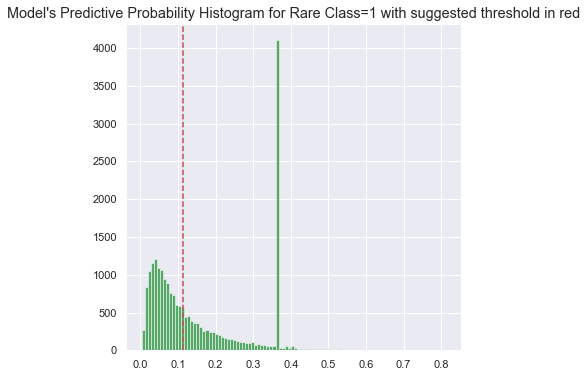

    Using threshold=0.5. However, 0.112 provides better F1=0.20 for rare class...
########################################################
XGBoost Model Prediction Results on Held Out CV Data Set:
    Regular Accuracy Score = 54.9%
Balanced Accuracy = 50.59% with Threshold = 0.50
Confusion Matrix:
[[20148    92]
 [ 1750    29]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     20240
           1       0.24      0.02      0.03      1779

    accuracy                           0.92     22019
   macro avg       0.58      0.51      0.49     22019
weighted avg       0.87      0.92      0.88     22019

Balanced Accuracy = 60.86% with Threshold = 0.11
Confusion Matrix:
[[10892  9348]
 [  571  1208]]
              precision    recall  f1-score   support

           0       0.95      0.54      0.69     20240
           1       0.11      0.68      0.20      1779

    accuracy                           0.55     22019
   macro avg       0.53    

Could not plot Model Evaluation Results Metrics
    Time taken for this Target (in seconds) = 35
    Binning_Flag set to False or there are no float vars in data set to be binned
CAUTION: Stacking can produce Highly Overfit models on Training Data...
    Adding 2 Stacking feature(s) to training data
Performing MinMax scaling of train and test data...
#####   T R A I N I N G   M O D E L   O N    F U L L   T R A I N  D A T A  #############
##################  Imbalanced Model Training  ############################
Imbalanced Training using SMOTE Rare Class Oversampling method...
Using SMOTE's over-sampling techniques to make the 2 classes balanced...
    class_weights = [0.54395925 6.18708553]
    class_weighted_rows = {0: 101196, 1: 55046}
Training model now on resampled train data: (156242, 15). This will take time...
    Resampled data Training time taken = 21 seconds
##################  Completed Imbalanced Training using XGBClassifier ################
     Actual Training time taken

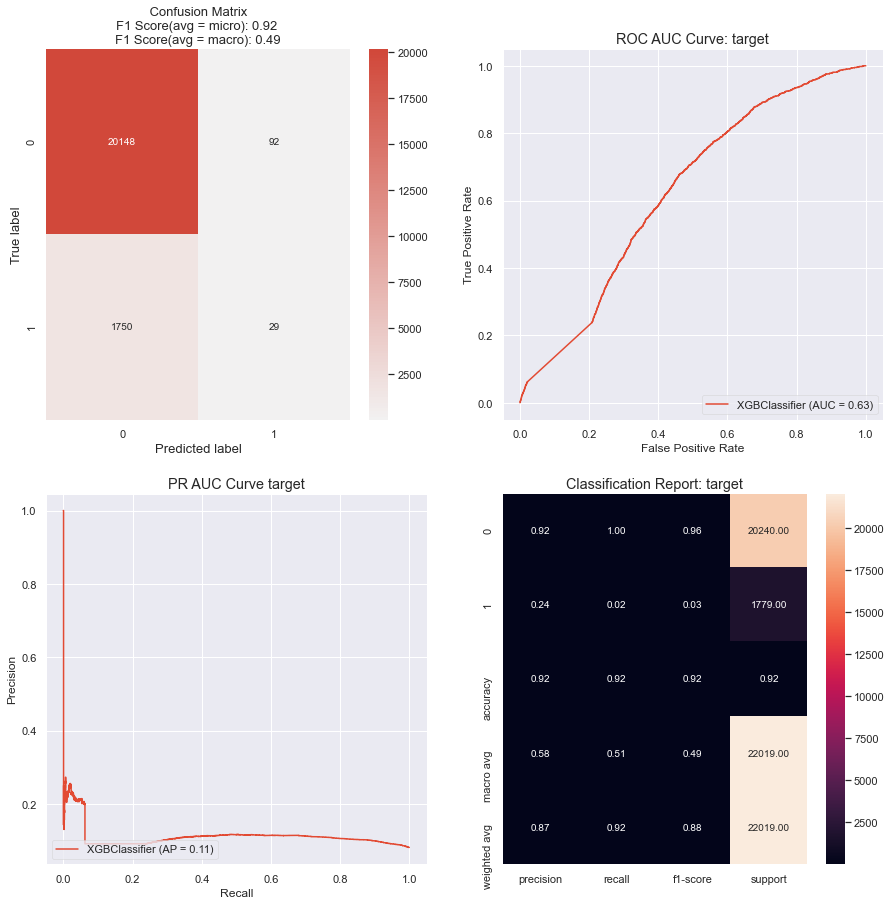

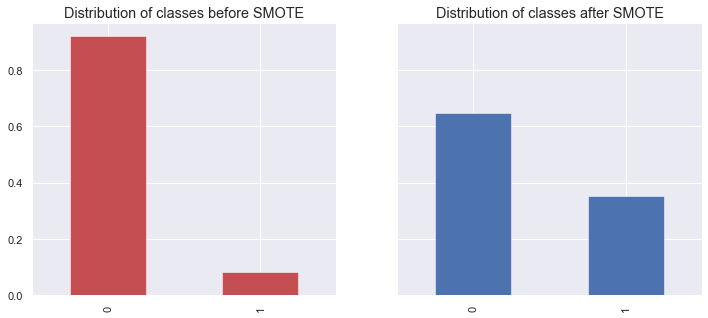

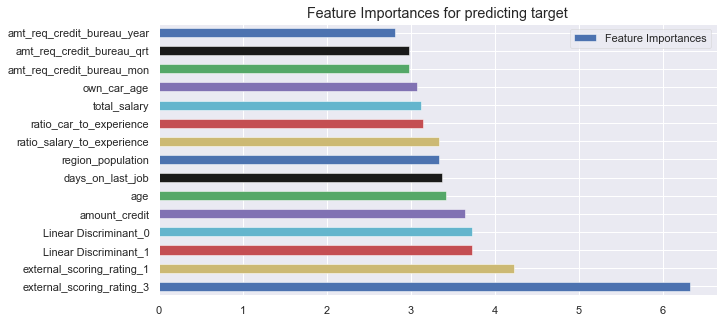

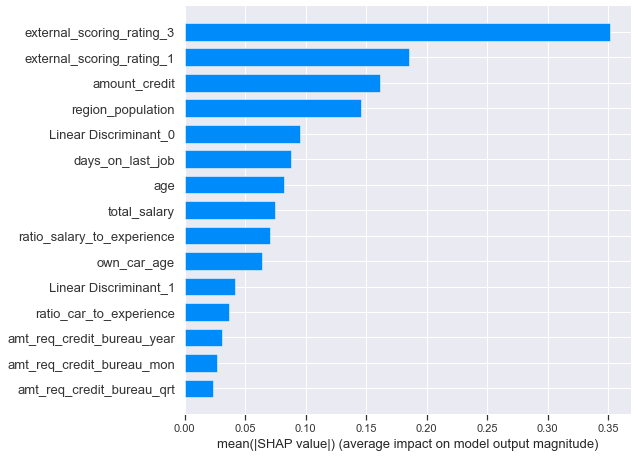

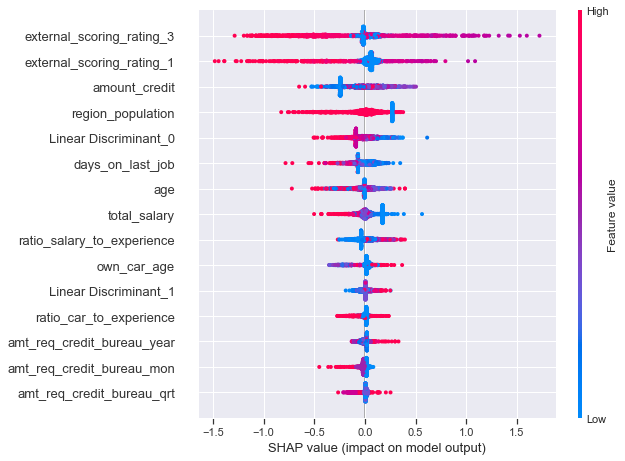

############### P R E D I C T I O N  O N  T E S T   C O M P L E T E D  #################
    Time taken thus far (in seconds) = 80
Writing Output files to disk...
    Saving predictions to .\target\target_Binary_Classification_test_modified.csv
    Saving predictions to .\target\target_Binary_Classification_submission.csv
    Saving predictions to .\target\target_Binary_Classification_train_modified.csv
###############  C O M P L E T E D  ################
Time Taken in mins = 1.7 for the Entire Process


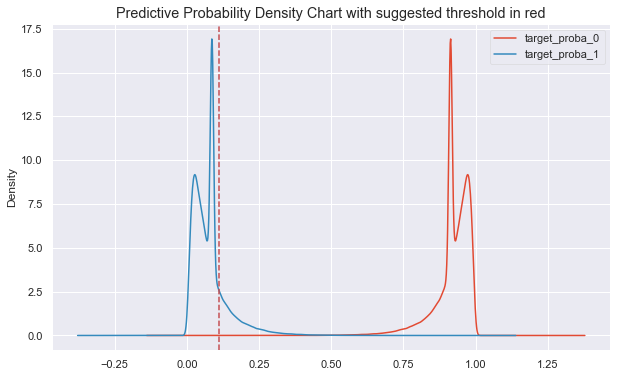

In [13]:
model, features, trainm, testm = Auto_ViML(
    train=train,
    target="target",
    test=test,
    sample_submission="",
    hyper_param="RS",
    feature_reduction=True,
    scoring_parameter="roc-auc",
    KMeans_Featurizer=False,
    Boosting_Flag=True,
    Binning_Flag=False,
    Add_Poly=False,
    Stacking_Flag=True,
    Imbalanced_Flag=True,
    verbose=3
)

##############  D A T A   S E T  A N A L Y S I S  #######################
ALERT! Changing hyperparameter search to RS. Otherwise XGBoost will take too long for 10,000+ rows.
Training Set Shape = (110093, 54)
    Training Set Memory Usage = 46.20 MB
Test Set Shape = (165141, 53)
    Test Set Memory Usage = 68.04 MB
Single_Label Target: ['target']
Random shuffling the data set before training
    Using RandomizedSearchCV for Hyper Parameter Tuning. This is 3X faster than GridSearchCV...
       Class  -> Counts -> Percent
         0.0:  101196  ->   91.9%
         1.0:    8897  ->    8.1%
    Target target is already numeric. No transformation done.
############## C L A S S I F Y I N G  V A R I A B L E S  ####################
Classifying variables in data set...
    53 Predictors classified...
        This does not include the Target column(s)
    1 variables removed since they were ID or low-information variables
        ['application_number']
Number of Processors on this device = 1
CPU 

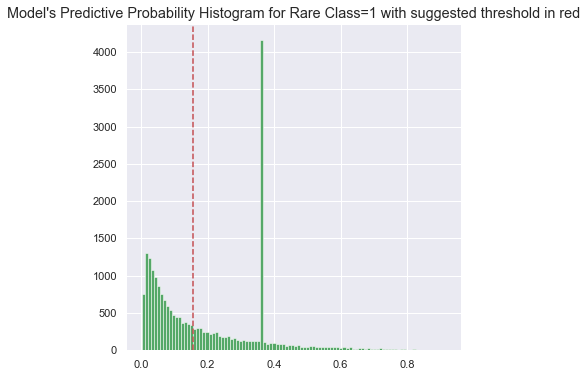

    Using threshold=0.5. However, 0.155 provides better F1=0.19 for rare class...
########################################################
XGBoost Model Prediction Results on Held Out CV Data Set:
    Regular Accuracy Score = 54.6%
Balanced Accuracy = 52.91% with Threshold = 0.50
Confusion Matrix:
[[19372   868]
 [ 1599   180]]
              precision    recall  f1-score   support

           0       0.92      0.96      0.94     20240
           1       0.17      0.10      0.13      1779

    accuracy                           0.89     22019
   macro avg       0.55      0.53      0.53     22019
weighted avg       0.86      0.89      0.87     22019

Balanced Accuracy = 59.19% with Threshold = 0.15
Confusion Matrix:
[[10864  9376]
 [  628  1151]]
              precision    recall  f1-score   support

           0       0.95      0.54      0.68     20240
           1       0.11      0.65      0.19      1779

    accuracy                           0.55     22019
   macro avg       0.53    

Could not plot Model Evaluation Results Metrics
    Time taken for this Target (in seconds) = 118
Determining which of 13 continuous variables should be Entropy Binned...
    Selected and binned only top 10 continuous variables.
    ['external_scoring_rating_3_bin', 'external_scoring_rating_1_bin', 'ratio_salary_to_experience_bin', 'amount_credit_bin', 'age_bin', 'days_on_last_job_bin', 'region_population_bin', 'own_car_age_bin', 'ratio_car_to_experience_bin', 'total_salary_bin']
CAUTION: Stacking can produce Highly Overfit models on Training Data...
    Adding 2 Stacking feature(s) to training data
Performing MinMax scaling of train and test data...
#####   T R A I N I N G   M O D E L   O N    F U L L   T R A I N  D A T A  #############
##################  Imbalanced Model Training  ############################
Imbalanced Training using SMOTE Rare Class Oversampling method...
Using SMOTE's over-sampling techniques to make the 2 classes balanced...
    class_weights = [0.54395925 6.187

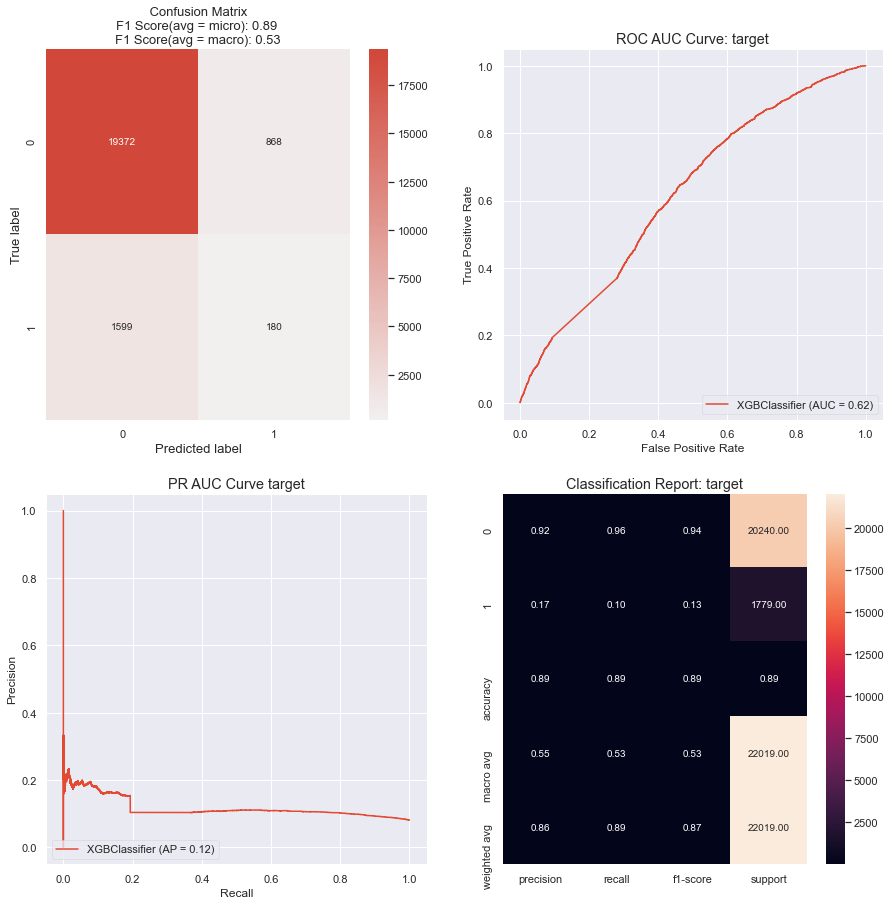

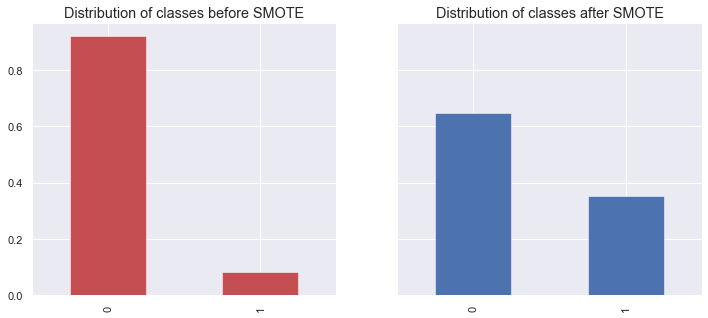

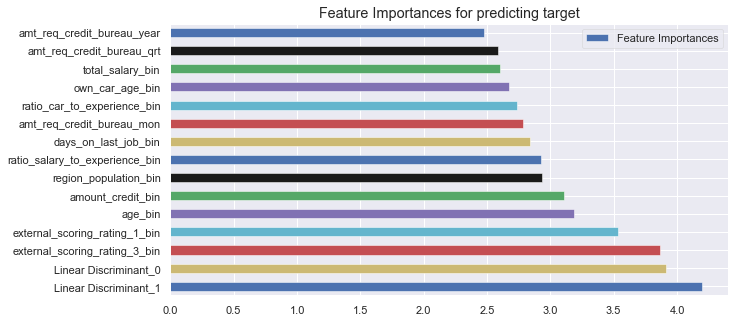

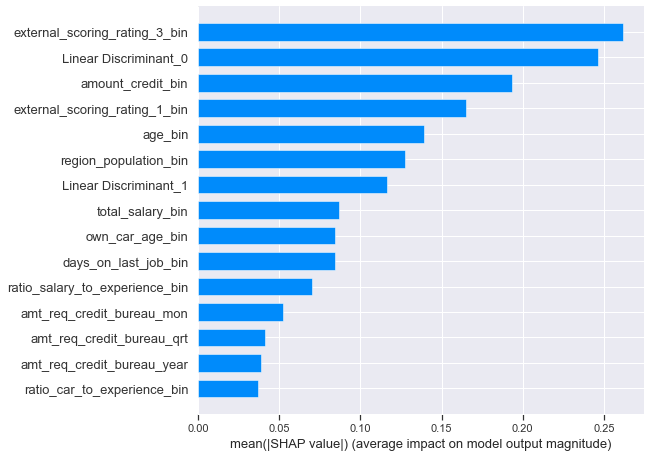

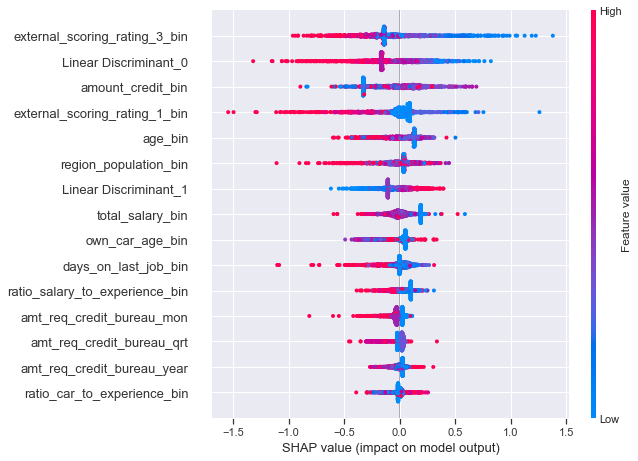

############### P R E D I C T I O N  O N  T E S T   C O M P L E T E D  #################
    Time taken thus far (in seconds) = 239
Writing Output files to disk...
    Saving predictions to .\target\target_Binary_Classification_test_modified.csv
    Saving predictions to .\target\target_Binary_Classification_submission.csv
    Saving predictions to .\target\target_Binary_Classification_train_modified.csv
###############  C O M P L E T E D  ################
Time Taken in mins = 4.4 for the Entire Process


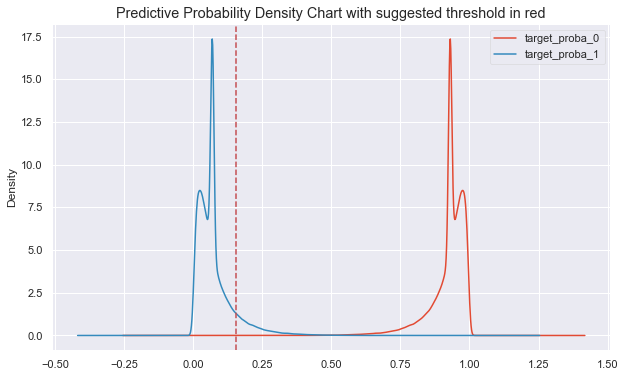

In [14]:
# Binning_Flag=True
model, features, trainm, testm = Auto_ViML(
    train=train,
    target="target",
    test=test,
    sample_submission="",
    hyper_param="RS",
    feature_reduction=True,
    scoring_parameter="roc-auc",
    KMeans_Featurizer=False,
    Boosting_Flag=True,
    Binning_Flag=True,
    Add_Poly=False,
    Stacking_Flag=True,
    Imbalanced_Flag=True,
    verbose=3
)

##############  D A T A   S E T  A N A L Y S I S  #######################
ALERT! Changing hyperparameter search to RS. Otherwise XGBoost will take too long for 10,000+ rows.
Training Set Shape = (110093, 54)
    Training Set Memory Usage = 51.20 MB
Test Set Shape = (165141, 53)
    Test Set Memory Usage = 73.04 MB
Single_Label Target: ['target']
Random shuffling the data set before training
    Using RandomizedSearchCV for Hyper Parameter Tuning. This is 3X faster than GridSearchCV...
       Class  -> Counts -> Percent
         0.0:  101196  ->   91.9%
         1.0:    8897  ->    8.1%
    Target target is already numeric. No transformation done.
############## C L A S S I F Y I N G  V A R I A B L E S  ####################
Classifying variables in data set...
    53 Predictors classified...
        This does not include the Target column(s)
    1 variables removed since they were ID or low-information variables
        ['application_number']
Number of Processors on this device = 1
CPU 

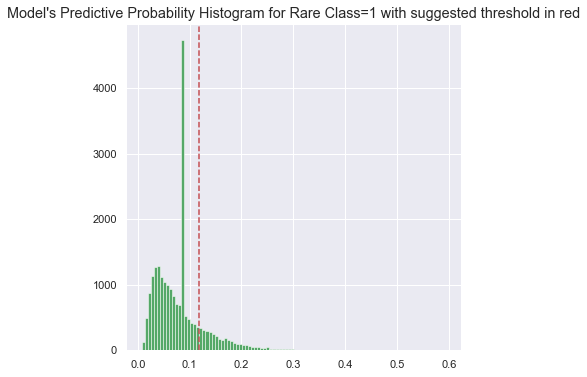

    Using threshold=0.5. However, 0.119 provides better F1=0.25 for rare class...
########################################################
XGBoost Model Prediction Results on Held Out CV Data Set:
    Regular Accuracy Score = 81.6%
Balanced Accuracy = 50.02% with Threshold = 0.50
Confusion Matrix:
[[20238     2]
 [ 1778     1]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     20240
           1       0.33      0.00      0.00      1779

    accuracy                           0.92     22019
   macro avg       0.63      0.50      0.48     22019
weighted avg       0.87      0.92      0.88     22019

Balanced Accuracy = 61.39% with Threshold = 0.12
Confusion Matrix:
[[17317  2923]
 [ 1117   662]]
              precision    recall  f1-score   support

           0       0.94      0.86      0.90     20240
           1       0.18      0.37      0.25      1779

    accuracy                           0.82     22019
   macro avg       0.56    

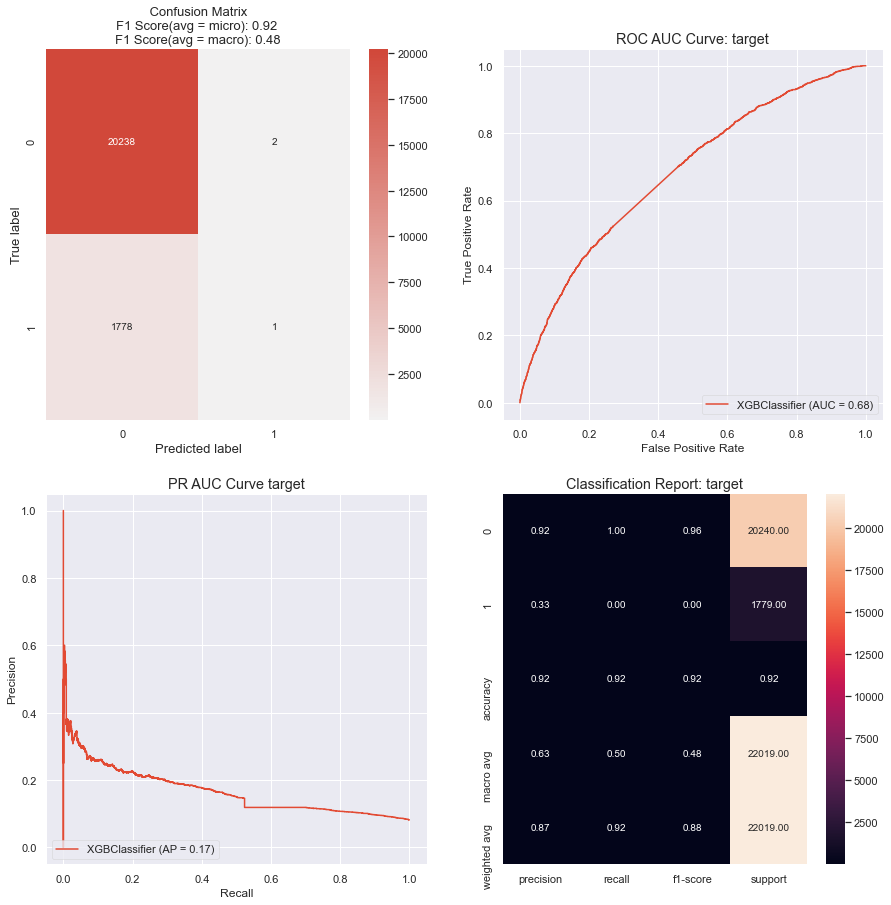

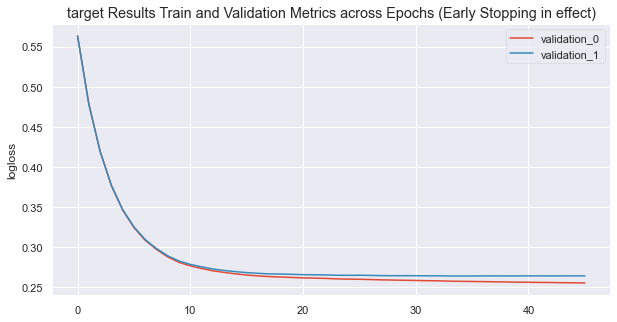

    Time taken for this Target (in seconds) = 469
    Binning_Flag set to False or there are no float vars in data set to be binned
CAUTION: Stacking can produce Highly Overfit models on Training Data...
    Adding 2 Stacking feature(s) to training data
Performing MinMax scaling of train and test data...
#####   T R A I N I N G   M O D E L   O N    F U L L   T R A I N  D A T A  #############
     Actual Training time taken in seconds = 10
Training of models completed. Now starting predictions on test data...
    Making test Data predictions using modified Threshold = 0.119
    Plotting Feature Importances to explain the output of model
Trying to plot SHAP values if SHAP is installed in this machine...


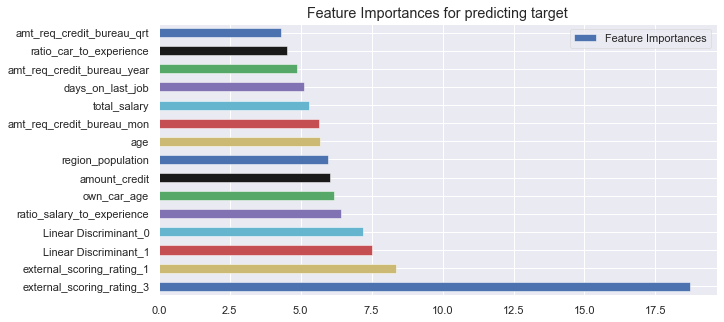

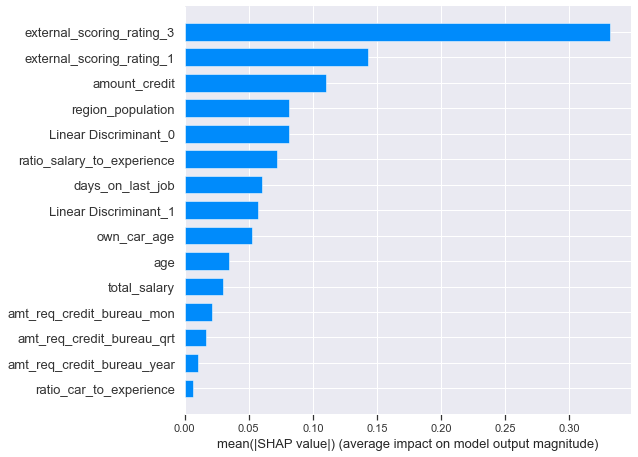

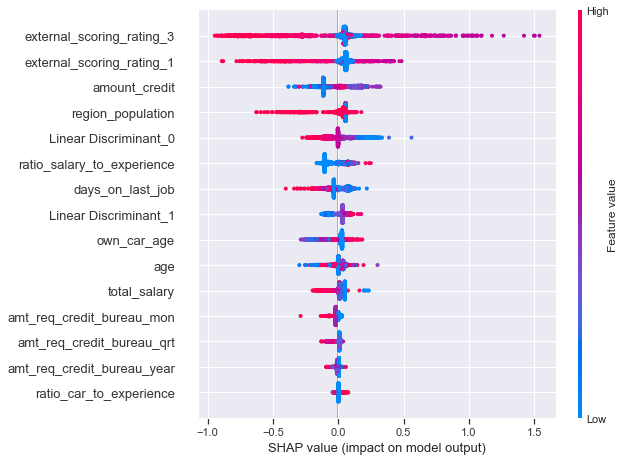

############### P R E D I C T I O N  O N  T E S T   C O M P L E T E D  #################
    Time taken thus far (in seconds) = 482
Writing Output files to disk...
    Saving predictions to .\target\target_Binary_Classification_test_modified.csv
    Saving predictions to .\target\target_Binary_Classification_submission.csv
    Saving predictions to .\target\target_Binary_Classification_train_modified.csv
###############  C O M P L E T E D  ################
Time Taken in mins = 8.4 for the Entire Process


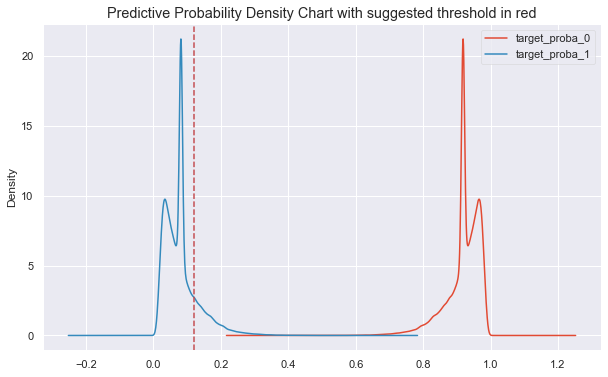

In [15]:
# Imbalanced_Flag=False
model, features, trainm, testm = Auto_ViML(
    train=train,
    target="target",
    test=test,
    sample_submission="",
    hyper_param="RS",
    feature_reduction=True,
    scoring_parameter="roc-auc",
    KMeans_Featurizer=False,
    Boosting_Flag=True,
    Binning_Flag=False,
    Add_Poly=False,
    Stacking_Flag=True,
    Imbalanced_Flag=False,
    verbose=3
)

##############  D A T A   S E T  A N A L Y S I S  #######################
ALERT! Changing hyperparameter search to RS. Otherwise XGBoost will take too long for 10,000+ rows.
Training Set Shape = (110093, 54)
    Training Set Memory Usage = 51.20 MB
Test Set Shape = (165141, 53)
    Test Set Memory Usage = 73.04 MB
Single_Label Target: ['target']
Random shuffling the data set before training
    Using RandomizedSearchCV for Hyper Parameter Tuning. This is 3X faster than GridSearchCV...
       Class  -> Counts -> Percent
         0.0:  101196  ->   91.9%
         1.0:    8897  ->    8.1%
    Target target is already numeric. No transformation done.
############## C L A S S I F Y I N G  V A R I A B L E S  ####################
Classifying variables in data set...
    53 Predictors classified...
        This does not include the Target column(s)
    1 variables removed since they were ID or low-information variables
        ['application_number']
Number of Processors on this device = 1
CPU 

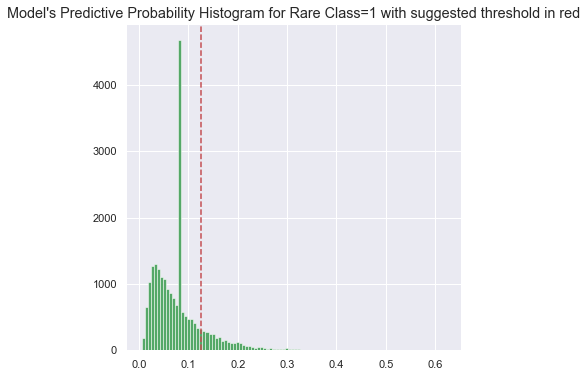

    Using threshold=0.5. However, 0.124 provides better F1=0.24 for rare class...
########################################################
XGBoost Model Prediction Results on Held Out CV Data Set:
    Regular Accuracy Score = 82.5%
Balanced Accuracy = 50.04% with Threshold = 0.50
Confusion Matrix:
[[20234     6]
 [ 1777     2]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     20240
           1       0.25      0.00      0.00      1779

    accuracy                           0.92     22019
   macro avg       0.58      0.50      0.48     22019
weighted avg       0.87      0.92      0.88     22019

Balanced Accuracy = 60.70% with Threshold = 0.12
Confusion Matrix:
[[17542  2698]
 [ 1161   618]]
              precision    recall  f1-score   support

           0       0.94      0.87      0.90     20240
           1       0.19      0.35      0.24      1779

    accuracy                           0.82     22019
   macro avg       0.56    

After multiple models, Ensemble Model Results:
Binary Class Model Metrics Report
#####################################################
    Accuracy          = 91.9%
    Balanced Accuracy = 50.0%
    Precision         = 5.9%
    Average Precision = 48.9%
    Recall            = 0.1%
    F1 Score          = 0.1%
#####################################################
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     20240
           1       0.06      0.00      0.00      1779

    accuracy                           0.92     22019
   macro avg       0.49      0.50      0.48     22019
weighted avg       0.85      0.92      0.88     22019

[[20224    16]
 [ 1778     1]]
#############################################################################
Single Model is better than Ensembling Models for this data set.


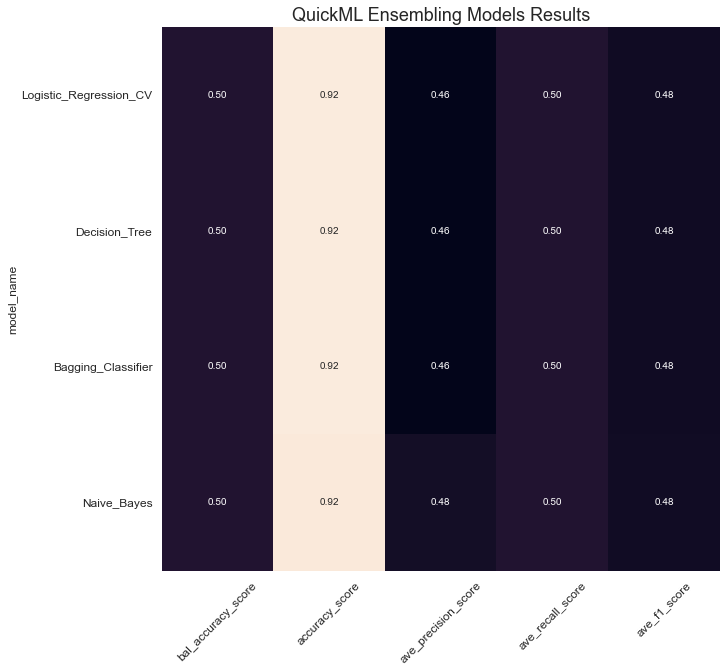

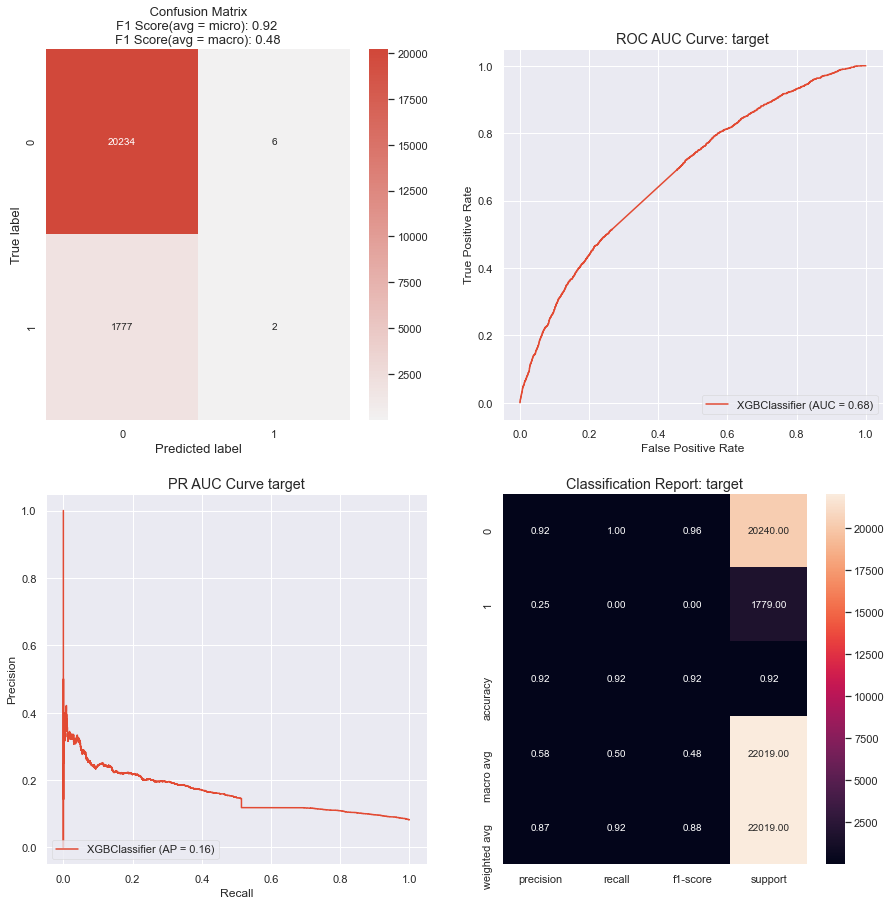

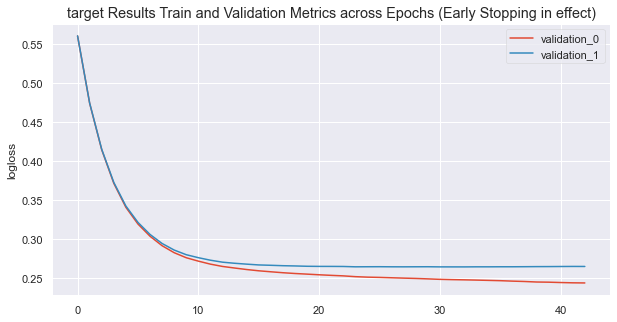

    Time taken for this Target (in seconds) = 447
    Binning_Flag set to False or there are no float vars in data set to be binned
Performing MinMax scaling of train and test data...
#####   T R A I N I N G   M O D E L   O N    F U L L   T R A I N  D A T A  #############
     Actual Training time taken in seconds = 17
Training of models completed. Now starting predictions on test data...
    Making test Data predictions using modified Threshold = 0.124
    Calculating weighted average ensemble of 5 classifiers
    Plotting Feature Importances to explain the output of model
Trying to plot SHAP values if SHAP is installed in this machine...


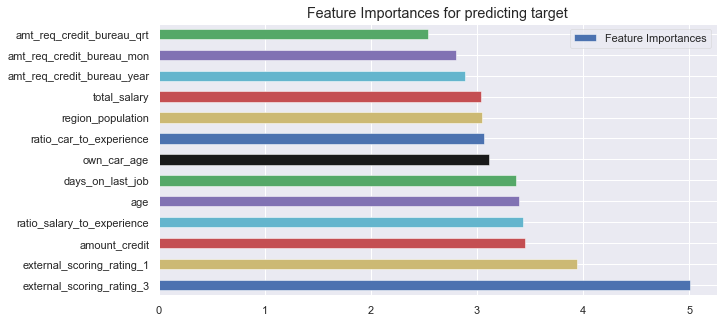

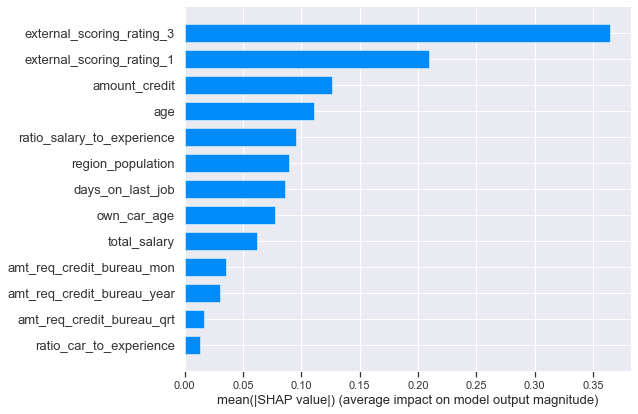

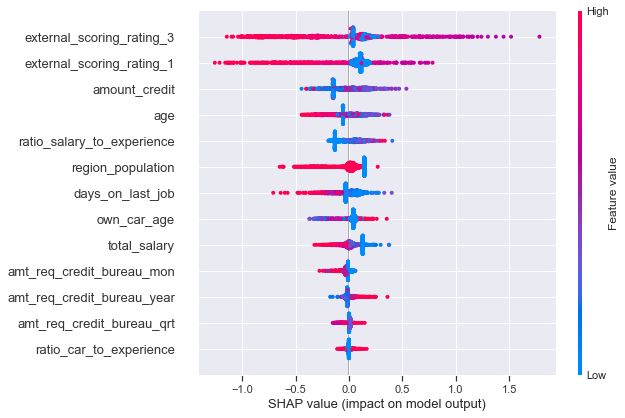

############### P R E D I C T I O N  O N  T E S T   C O M P L E T E D  #################
    Time taken thus far (in seconds) = 481
Writing Output files to disk...
    Saving predictions to .\target\target_Binary_Classification_test_modified.csv
    Saving predictions to .\target\target_Binary_Classification_submission.csv
    Saving predictions to .\target\target_Binary_Classification_train_modified.csv
###############  C O M P L E T E D  ################
Time Taken in mins = 8.4 for the Entire Process


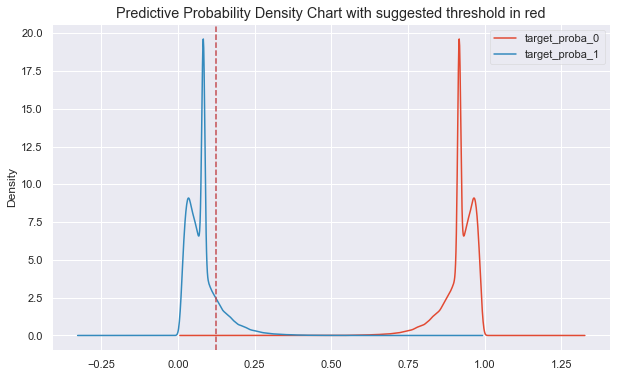

In [16]:
# Imbalanced_Flag=False
# Stacking_Flag=False
model, features, trainm, testm = Auto_ViML(
    train=train,
    target="target",
    test=test,
    sample_submission="",
    hyper_param="RS",
    feature_reduction=True,
    scoring_parameter="roc-auc",
    KMeans_Featurizer=False,
    Boosting_Flag=True,
    Binning_Flag=False,
    Add_Poly=False,
    Stacking_Flag=False,
    Imbalanced_Flag=False,
    verbose=3
)

##############  D A T A   S E T  A N A L Y S I S  #######################
Training Set Shape = (110093, 54)
    Training Set Memory Usage = 46.20 MB
Test Set Shape = (165141, 53)
    Test Set Memory Usage = 68.04 MB
Single_Label Target: ['target']
Random shuffling the data set before training
    Using RandomizedSearchCV for Hyper Parameter Tuning. This is 3X faster than GridSearchCV...
       Class  -> Counts -> Percent
         0.0:  101196  ->   91.9%
         1.0:    8897  ->    8.1%
    Target target is already numeric. No transformation done.
############## C L A S S I F Y I N G  V A R I A B L E S  ####################
Classifying variables in data set...
    53 Predictors classified...
        This does not include the Target column(s)
    1 variables removed since they were ID or low-information variables
        ['application_number']
Number of Processors on this device = 1
CPU available
    No GPU active on this device
#############     D A T A    P R E P A R A T I O N   AND 

0:	learn: 0.7520901	test: 0.9191816	test1: 0.9192061	best: 0.9192061 (0)	total: 254ms	remaining: 42m 21s
500:	learn: 0.8763691	test: 0.9193633	test1: 0.9190245	best: 0.9192061 (0)	total: 10.6s	remaining: 3m 20s
1000:	learn: 0.8800173	test: 0.9201013	test1: 0.9187520	best: 0.9192061 (0)	total: 20.7s	remaining: 3m 5s
1500:	learn: 0.8820094	test: 0.9208734	test1: 0.9187520	best: 0.9192061 (0)	total: 31.1s	remaining: 2m 56s
2000:	learn: 0.8837295	test: 0.9219974	test1: 0.9189336	best: 0.9192061 (0)	total: 42.2s	remaining: 2m 48s
Stopped by overfitting detector  (2000 iterations wait)

bestTest = 0.9192061402
bestIteration = 0

Shrink model to first 1 iterations.
    Resampled data Training time taken = 43 seconds
########################################################
Resampled model results on Held out Validation data:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     80956
           1       0.00      0.00      0.00      7118

    acc

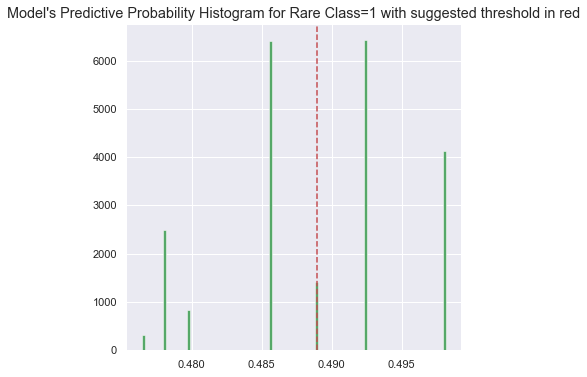

    Using threshold=0.5. However, 0.489 provides better F1=0.19 for rare class...
########################################################
CatBoost Model Prediction Results on Held Out CV Data Set:
    Regular Accuracy Score = 54.0%
Balanced Accuracy = 50.00% with Threshold = 0.50
Confusion Matrix:
[[20240     0]
 [ 1779     0]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     20240
           1       0.00      0.00      0.00      1779

    accuracy                           0.92     22019
   macro avg       0.46      0.50      0.48     22019
weighted avg       0.84      0.92      0.88     22019

Balanced Accuracy = 59.43% with Threshold = 0.49
Confusion Matrix:
[[ 9541 10699]
 [  503  1276]]
              precision    recall  f1-score   support

           0       0.95      0.47      0.63     20240
           1       0.11      0.72      0.19      1779

    accuracy                           0.49     22019
   macro avg       0.53   

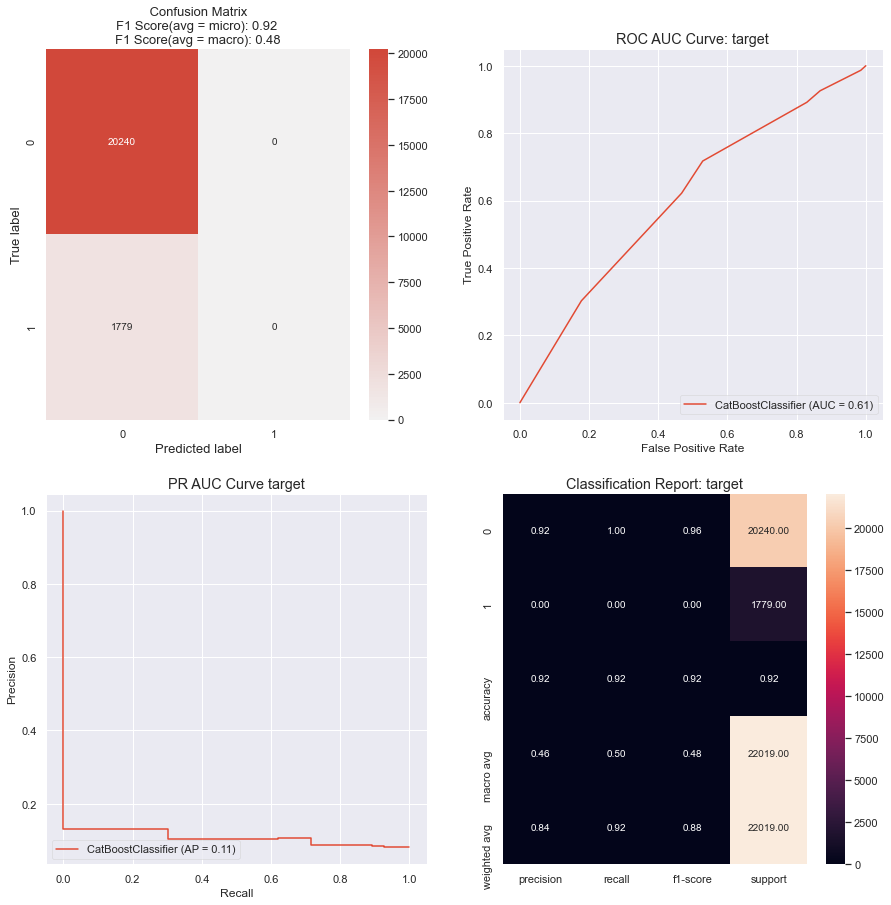

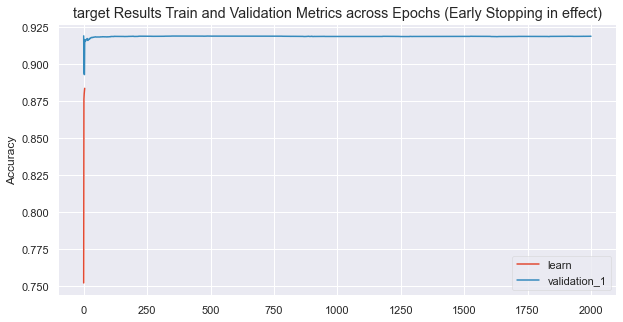

    Time taken for this Target (in seconds) = 67
    Binning_Flag set to False or there are no float vars in data set to be binned
CAUTION: Stacking can produce Highly Overfit models on Training Data...
    Adding 2 Stacking feature(s) to training data
    Setting best params for CatBoost model from Initial State since you cannot change params to a fitted Catboost model 
    Number of Categorical and Integer variables used in CatBoost training = 0
No MinMax scaling performed since scaling flag is set to false
#####   T R A I N I N G   M O D E L   O N    F U L L   T R A I N  D A T A  #############
##################  Imbalanced Model Training  ############################
Imbalanced Training using SMOTE Rare Class Oversampling method...
Using SMOTE's over-sampling techniques to make the 2 classes balanced...
    class_weights = [0.54395925 6.18708553]
    class_weighted_rows = {0: 101196, 1: 55046}
Training model now on resampled train data: (156242, 15). This will take time...
Learning

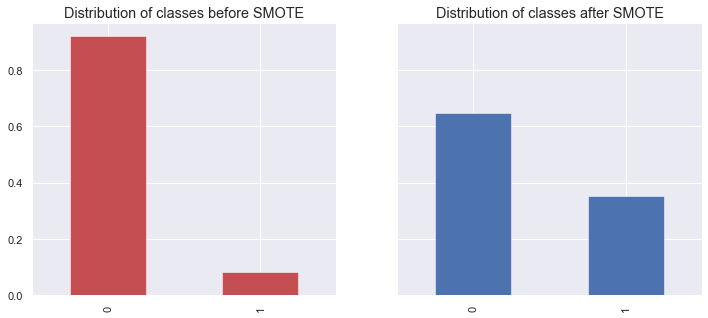

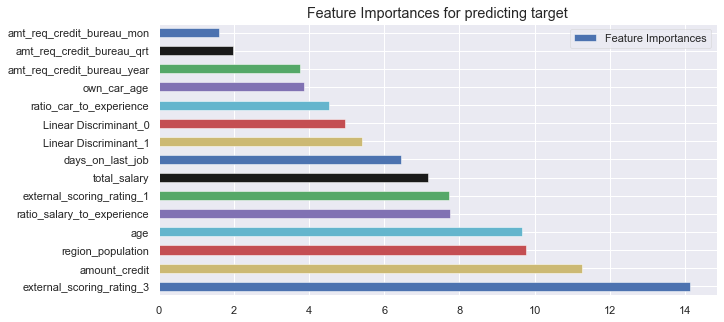

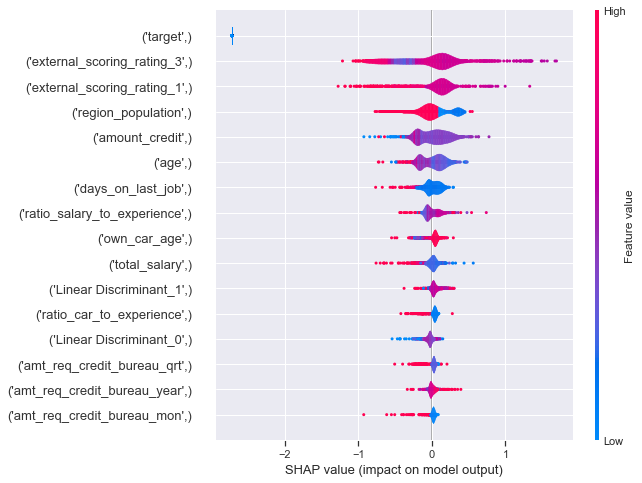

############### P R E D I C T I O N  O N  T E S T   C O M P L E T E D  #################
    Time taken thus far (in seconds) = 565
Writing Output files to disk...
    Saving predictions to .\target\target_Binary_Classification_test_modified.csv
    Saving predictions to .\target\target_Binary_Classification_submission.csv
    Saving predictions to .\target\target_Binary_Classification_train_modified.csv
###############  C O M P L E T E D  ################
Time Taken in mins = 9.7 for the Entire Process


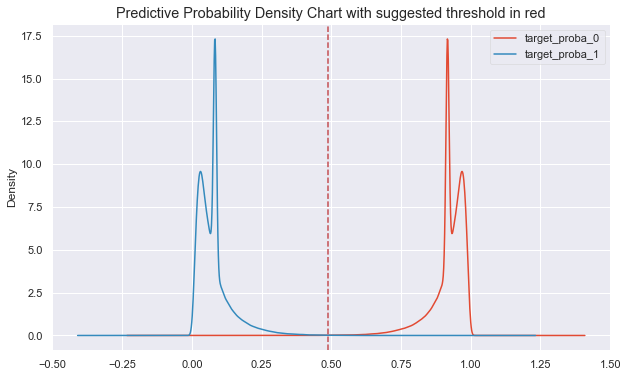

In [13]:
# Boosting_Flag="CatBoost"
model, features, trainm, testm = Auto_ViML(
    train=train,
    target="target",
    test=test,
    sample_submission="",
    hyper_param="RS",
    feature_reduction=True,
    scoring_parameter="roc-auc",
    KMeans_Featurizer=False,
    Boosting_Flag="CatBoost",
    Binning_Flag=False,
    Add_Poly=False,
    Stacking_Flag=True,
    Imbalanced_Flag=True,
    verbose=3
)